# Chapter 7 - Notes

#### 7.1

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
from torchvision import datasets

In [3]:
data_path = 'data_unversioned/chapter07/'

In [4]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified


In [6]:
# taken from another notebook
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [7]:
len(cifar10_val)

10000

In [8]:
len(cifar10)

50000

In [9]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FE9EF434128>,
 1,
 'automobile')

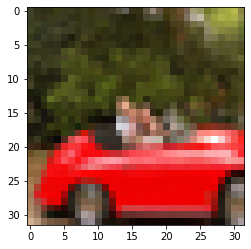

In [10]:
plt.imshow(img)
plt.show()

In [11]:
from torchvision import transforms

In [12]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [13]:
to_tensor = transforms.ToTensor()

In [14]:
img_t = to_tensor(img)

In [15]:
img_t.shape

torch.Size([3, 32, 32])

In [16]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

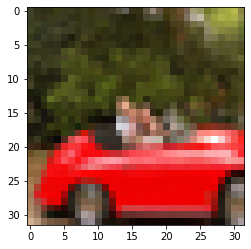

In [17]:
plt.imshow(img_t.permute(1,2,0)) # permute changes the order of the layers: index=1 to 0 position, index=2 to 1 position and index=0 to 2 position
plt.show()

In [18]:
# normalization

imgs = torch.stack([to_tensor(img_t) for img_t, _ in cifar10], dim=3) # this should add an additional layer: 3chan, rows, widths, images
imgs.shape

torch.Size([3, 32, 32, 50000])

In [19]:
imgs.view(3,-1).shape

torch.Size([3, 51200000])

In [20]:
means_np = imgs.view(3,-1).mean(dim=1).numpy() # keep the first dimension
means_np

array([0.49147   , 0.48226798, 0.44678035], dtype=float32)

In [21]:
stds_np = imgs.view(3,-1).std(dim=1).numpy() # keep the first dimension
stds_np

array([0.24703224, 0.24348514, 0.26158786], dtype=float32)

In [22]:
# now we can normalize our images
transforms.Normalize(mean=means_np, std=stds_np)

Normalize(mean=[0.49147    0.48226798 0.44678035], std=[0.24703224 0.24348514 0.26158786])

In [23]:
# we can combine everything: downloading, converting to tensors, normalizing in a single command
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                transforms.Normalize(mean=means_np, std=stds_np)]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                transforms.Normalize(mean=means_np, std=stds_np)]))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


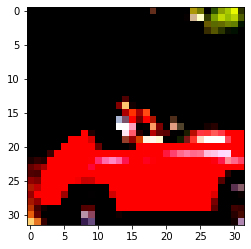

In [24]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

#### 7.2 Birds from Planes

In [25]:
# get only birds and planes
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

# build a list of tuples with (image, class_name)
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in label_map.keys()]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in label_map.keys()]
len(cifar2)

10000

In [26]:
# build a simple model
import torch.nn as nn

n_out = 2 # number of classes

model = nn.Sequential( 
    nn.Linear( 3072, 512), # 3color-channels x 32 pixels h x 32 pixels w
    nn.Tanh(), # activation
    nn.Linear( 512, n_out) # inout of previous layer, output is number of classes
)

In [27]:
# add softmax to our model
n_out = 2 # number of classes

model = nn.Sequential( 
    nn.Linear( 3072, 512), # 3color-channels x 32 pixels h x 32 pixels w
    nn.Tanh(), # activation
    nn.Linear( 512, n_out), # inout of previous layer, output is number of classes
    nn.Softmax(dim=1), # constrain the output to probabilities
)

##### try it all out

In [28]:
type(cifar2[0][0])

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


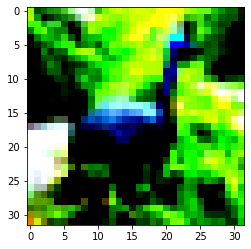

In [29]:
img, _ = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [30]:
img.shape

torch.Size([3, 32, 32])

In [31]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [32]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [33]:
out.sum()

tensor(1., grad_fn=<SumBackward0>)

In [34]:
# rebuild model with logsoftmax

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

In [35]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))
out

tensor([[-0.9210, -0.5077]], grad_fn=<LogSoftmaxBackward>)

In [36]:
loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward>)

##### 7.2.6 TRAINING

In [37]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

In [38]:
learning_rate = 1e-2

n_epochs = 10

In [39]:
import torch.optim as optim

In [40]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
loss_fn = nn.NLLLoss()

In [42]:
# training loop 
for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 3.620951
Epoch: 1, Loss: 8.930984
Epoch: 2, Loss: 3.748525
Epoch: 3, Loss: 9.138787
Epoch: 4, Loss: 8.081260
Epoch: 5, Loss: 8.360019
Epoch: 6, Loss: 5.469048
Epoch: 7, Loss: 4.914627
Epoch: 8, Loss: 0.491294
Epoch: 9, Loss: 8.249778


In [43]:
# training loop with dataloader and minibatching

train_loader = torch.utils.data.DataLoader(cifar2, 
                                          batch_size=64,
                                          shuffle=True)

In [44]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

In [45]:
learning_rate = 1e-2

n_epochs = 100

In [46]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [47]:
loss_fn = nn.NLLLoss()

In [48]:
# training loop 
for epoch in range(n_epochs):
    #for img, label in cifar2:
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # keep the batch size shape and combine other dimensions, should be 64, 3072
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.481771
Epoch: 1, Loss: 0.501275
Epoch: 2, Loss: 0.390120
Epoch: 3, Loss: 0.386306
Epoch: 4, Loss: 0.282170
Epoch: 5, Loss: 0.464191
Epoch: 6, Loss: 0.247053
Epoch: 7, Loss: 0.129157
Epoch: 8, Loss: 0.727424
Epoch: 9, Loss: 0.633602
Epoch: 10, Loss: 0.197042
Epoch: 11, Loss: 0.264321
Epoch: 12, Loss: 0.609003
Epoch: 13, Loss: 0.313753
Epoch: 14, Loss: 0.511905
Epoch: 15, Loss: 0.529331
Epoch: 16, Loss: 0.330996
Epoch: 17, Loss: 0.259470
Epoch: 18, Loss: 0.430758
Epoch: 19, Loss: 0.215577
Epoch: 20, Loss: 0.186790
Epoch: 21, Loss: 0.223844
Epoch: 22, Loss: 0.277760
Epoch: 23, Loss: 0.231305
Epoch: 24, Loss: 0.268665
Epoch: 25, Loss: 0.313870
Epoch: 26, Loss: 0.405688
Epoch: 27, Loss: 0.156327
Epoch: 28, Loss: 0.309119
Epoch: 29, Loss: 0.368717
Epoch: 30, Loss: 0.275559
Epoch: 31, Loss: 0.056792
Epoch: 32, Loss: 0.228569
Epoch: 33, Loss: 0.237882
Epoch: 34, Loss: 0.119111
Epoch: 35, Loss: 0.222088
Epoch: 36, Loss: 0.302887
Epoch: 37, Loss: 0.219976
Epoch: 38, Loss: 0.087

In [49]:
batch_size

16

In [50]:
# evaluation of model

val_loader = torch.utils.data.DataLoader(cifar2_val, 
                                        batch_size=64,
                                        shuffle=False)

correct, total = 0, 0

with torch.no_grad(): # do not update the gradient graph
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _ , predicted = torch.max(outputs,dim=1) # get the index of the predicted value, which is also the class label
        total += predicted.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct/total))

Accuracy: 0.822000


##### Update the model capacity/complexity

In [51]:
# training loop with dataloader and minibatching

train_loader = torch.utils.data.DataLoader(cifar2, 
                                          batch_size=64,
                                          shuffle=True)

In [52]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
) # remove nn.LogSoftMax --> this will be combined with NLLLoss to form nn.CrossEntropyLoss

In [53]:
learning_rate = 1e-2

n_epochs = 100

In [54]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [55]:
loss_fn = nn.CrossEntropyLoss() # nn.NLLLoss() combined with nn.LogSoftMax()

In [56]:
# training loop 
for epoch in range(n_epochs):
    #for img, label in cifar2:
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1)) # keep the batch size shape and combine other dimensions, should be 64, 3072
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.643236
Epoch: 1, Loss: 0.392587
Epoch: 2, Loss: 0.483444
Epoch: 3, Loss: 0.737715
Epoch: 4, Loss: 0.332684
Epoch: 5, Loss: 0.261721
Epoch: 6, Loss: 0.482505
Epoch: 7, Loss: 0.630774
Epoch: 8, Loss: 0.353518
Epoch: 9, Loss: 0.243654
Epoch: 10, Loss: 0.414934
Epoch: 11, Loss: 0.543494
Epoch: 12, Loss: 0.168706
Epoch: 13, Loss: 0.211954
Epoch: 14, Loss: 0.302980
Epoch: 15, Loss: 0.247812
Epoch: 16, Loss: 0.258206
Epoch: 17, Loss: 0.485112
Epoch: 18, Loss: 0.444749
Epoch: 19, Loss: 0.332640
Epoch: 20, Loss: 0.840817
Epoch: 21, Loss: 0.283946
Epoch: 22, Loss: 0.287798
Epoch: 23, Loss: 0.314825
Epoch: 24, Loss: 0.225453
Epoch: 25, Loss: 0.520396
Epoch: 26, Loss: 0.201925
Epoch: 27, Loss: 0.182423
Epoch: 28, Loss: 0.302123
Epoch: 29, Loss: 0.203261
Epoch: 30, Loss: 0.194028
Epoch: 31, Loss: 0.317247
Epoch: 32, Loss: 0.126305
Epoch: 33, Loss: 0.537732
Epoch: 34, Loss: 0.236388
Epoch: 35, Loss: 0.125635
Epoch: 36, Loss: 0.017851
Epoch: 37, Loss: 0.219599
Epoch: 38, Loss: 0.220

In [57]:
# evaluation of model

val_loader = torch.utils.data.DataLoader(cifar2_val, 
                                        batch_size=64,
                                        shuffle=False)

correct, total = 0, 0

with torch.no_grad(): # do not update the gradient graph
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _ , predicted = torch.max(outputs,dim=1) # get the index of the predicted value, which is also the class label
        total += predicted.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct/total))

Accuracy: 0.814000


In [58]:
# Parameter count

parameter_count = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(parameter_count), parameter_count

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])